In [78]:
%reload_ext autoreload

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import env
import acquire

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures

from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")




In [79]:
np.random.seed(123)
df = acquire.get_zillow_data_from_sql()
df

,bathrooms,bedrooms,square_feet,fips,home_value
0,2.0,3.0,1458.0,6037.0,136104.0
1,1.0,2.0,1421.0,6037.0,35606.0
2,3.0,4.0,2541.0,6059.0,880456.0
3,2.0,3.0,1650.0,6037.0,614000.0
4,1.0,2.0,693.0,6037.0,274237.0
...,...,...,...,...,...
15031,3.0,5.0,2526.0,6059.0,458903.0
15032,3.0,5.0,2735.0,6059.0,115387.0
15033,2.0,3.0,1536.0,6037.0,297097.0
15034,3.0,5.0,2655.0,6059.0,746963.0


In [3]:
df.shape

(15036, 5)

In [4]:
# Okay, so 15,036 observations 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Data columns (total 5 columns):
bathrooms      15036 non-null float64
bedrooms       15036 non-null float64
square_feet    15012 non-null float64
fips           15036 non-null float64
home_value     15036 non-null float64
dtypes: float64(5)
memory usage: 587.5 KB


In [5]:
df.isnull().sum()

bathrooms       0
bedrooms        0
square_feet    24
fips            0
home_value      0
dtype: int64

#### Looks like 'square_feet' has null values.  Being that the dataset is so large (15,036 rows), it is not likely that dropping 24 of them will have an adverse affect on our projections.

#### First, find out which rows have the nulls in them:

In [6]:
# Checks to see if ANY values in the rows are null

sq_ft_nulls = df[df.isnull().any(axis=1)]["square_feet"]
sq_ft_nulls

280     NaN
920     NaN
921     NaN
940     NaN
2629    NaN
4096    NaN
5553    NaN
6585    NaN
6942    NaN
8514    NaN
8957    NaN
9603    NaN
9797    NaN
11019   NaN
11249   NaN
11544   NaN
11848   NaN
12134   NaN
12305   NaN
12517   NaN
13259   NaN
13791   NaN
13829   NaN
14978   NaN
Name: square_feet, dtype: float64

In [7]:
# tax_amount_nulls = df[df.isnull().any(axis=1)]["tax_amount"]
# tax_amount_nulls

In [8]:
df = df.dropna(how='any',axis=0) 

#### Check to see if that worked

In [9]:
df

,bathrooms,bedrooms,square_feet,fips,home_value
0,2.0,3.0,1458.0,6037.0,136104.0
1,1.0,2.0,1421.0,6037.0,35606.0
2,3.0,4.0,2541.0,6059.0,880456.0
3,2.0,3.0,1650.0,6037.0,614000.0
4,1.0,2.0,693.0,6037.0,274237.0
...,...,...,...,...,...
15031,3.0,5.0,2526.0,6059.0,458903.0
15032,3.0,5.0,2735.0,6059.0,115387.0
15033,2.0,3.0,1536.0,6037.0,297097.0
15034,3.0,5.0,2655.0,6059.0,746963.0


#### Checking a random row from the 'square_feet' column that should have been dropped:

In [10]:
print(df.loc[[11544]])

KeyError: "None of [Int64Index([11544], dtype='int64')] are in the [index]"

#### Checking the row from 'tax_amount' that should have been dropped

In [11]:
#print(df.loc[[5180]])

#### Looks good.  The math for the total rows after 24 drops checks out, and none of the rows were available to print. 

In [12]:
(df == 0).sum(axis=1)

0        0
1        0
2        0
3        0
4        0
        ..
15031    0
15032    0
15033    0
15034    0
15035    0
Length: 15012, dtype: int64

#### No zero values for bathrooms, bedrooms, square_feet, or home_value.  Good.

### Time to take a look at things; quick overview

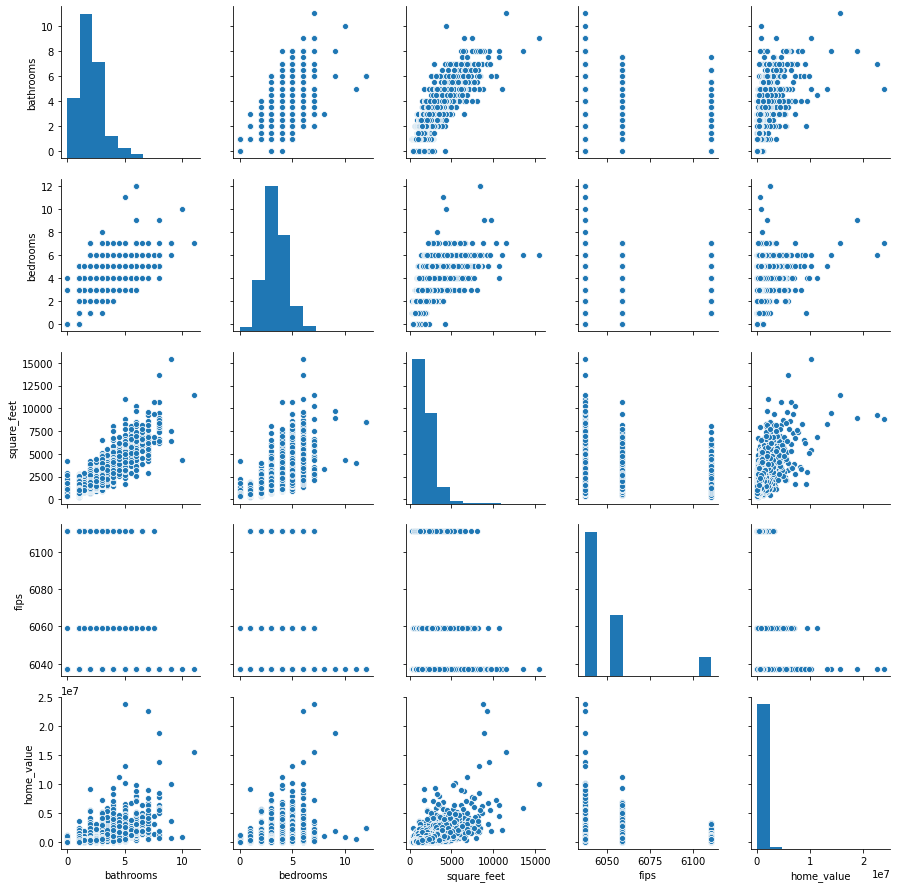

In [13]:
sns.pairplot(df);

## Selecting features 

### Now, the fun part.  What's related, and what's not.  

In [14]:
df.head()

,bathrooms,bedrooms,square_feet,fips,home_value
0,2.0,3.0,1458.0,6037.0,136104.0
1,1.0,2.0,1421.0,6037.0,35606.0
2,3.0,4.0,2541.0,6059.0,880456.0
3,2.0,3.0,1650.0,6037.0,614000.0
4,1.0,2.0,693.0,6037.0,274237.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15012 entries, 0 to 15035
Data columns (total 5 columns):
bathrooms      15012 non-null float64
bedrooms       15012 non-null float64
square_feet    15012 non-null float64
fips           15012 non-null float64
home_value     15012 non-null float64
dtypes: float64(5)
memory usage: 1.3 MB


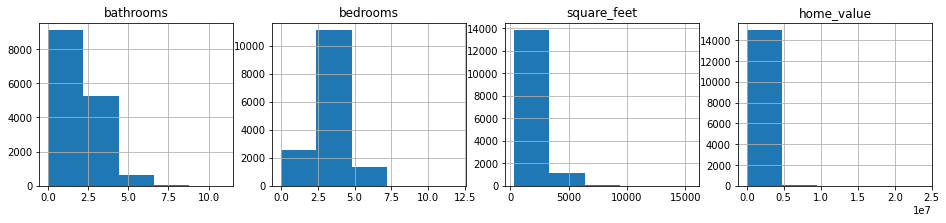

In [16]:
plt.figure(figsize=(16, 3))

for i, col in enumerate(["bathrooms", "bedrooms", "square_feet", "home_value"]):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(1,4, plot_number)
    plt.title(col)
    series.hist(bins=5)

### Histogram's telling me that the most houses are (roughly) 3.5bdr, 2bath, 2,200sqft and cost about `$`250,000.

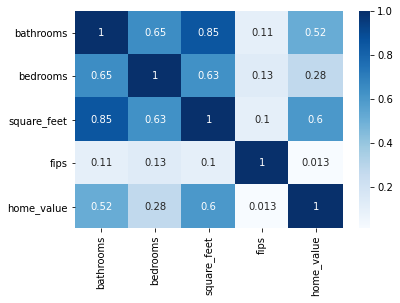

In [17]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="Blues") # Blues chosen in honor of Zillow's color palate

### Heat map's telling me that 'home_value' is most closely correlated to 'square_feet.'

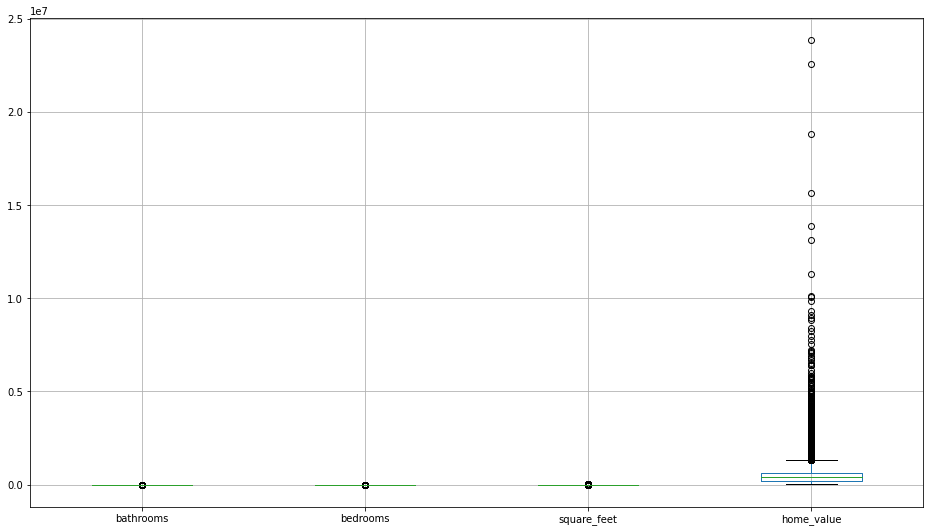

In [18]:
plt.figure(figsize=(16, 9))
df.boxplot(column=["bathrooms", "bedrooms", "square_feet", "home_value"])


### Ugh.  Box plot tells me nothing other than differing value metrics (smells like some splitting and scaling needs to be done).

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
train, test = train_test_split(df, train_size=.80, random_state=123)
print(train.shape)
print(test.shape)

(12009, 5)
(3003, 5)


In [21]:
X = df[["bathrooms", "bedrooms", "square_feet"]]
y = df["home_value"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, train_size=.80, random_state=123)

print(X_train)

       bathrooms  bedrooms  square_feet
1233         2.0       3.0       1264.0
6499         1.0       3.0       1590.0
6025         2.5       4.0       1560.0
3160         2.0       4.0       2194.0
13880        2.5       4.0       2538.0
...          ...       ...          ...
5224         2.0       6.0       1352.0
12270        5.0       5.0       2950.0
1350         5.0       6.0       3674.0
11662        2.0       5.0       2705.0
3587         2.0       4.0       1317.0

[12009 rows x 3 columns]


In [23]:
print(X_test)

       bathrooms  bedrooms  square_feet
7095         2.0       3.0       2006.0
13621        2.0       2.0       1513.0
7681         3.0       4.0       2136.0
3571         2.0       3.0       1604.0
2420         2.5       3.0       2759.0
...          ...       ...          ...
11035        3.0       4.0       2629.0
9896         2.0       4.0       1733.0
11696        2.0       3.0       1296.0
3143         2.0       2.0       1136.0
10738        2.0       4.0       1578.0

[3003 rows x 3 columns]


In [24]:
print(y_train)

1233     453460.0
6499     477113.0
6025     354054.0
3160     118128.0
13880    774974.0
           ...   
5224     275268.0
12270    976000.0
1350     945000.0
11662    630080.0
3587     199717.0
Name: home_value, Length: 12009, dtype: float64


In [25]:
print(y_test)

7095      647955.0
13621     483373.0
7681      738000.0
3571      539525.0
2420      797339.0
           ...    
11035    1047968.0
9896      508658.0
11696      62066.0
3143     1144258.0
10738      96458.0
Name: home_value, Length: 3003, dtype: float64


#### Looks like I'm testing 3,003 rows of data based on what my model's learning after training for Drago with 12,009 rows of data - Using StandardScaler to scale data to Normal Distribution

In [26]:
scaler1 = StandardScaler(copy=True, with_mean=True, with_std=True).fit(train)
scaler1

StandardScaler(copy=True, with_mean=True, with_std=True)

#### Now to look at the mean and standard deviation that'll be transforming our data

In [27]:
import math

print("Mean = ")
print(scaler1.mean_)
print("Standard Deviation = ")
print([math.sqrt(i) for i in scaler1.var_])

Mean = 
[2.33483221e+00 3.31776168e+00 1.95132517e+03 6.04935940e+03
 5.44091834e+05]
Standard Deviation = 
[1.0335225431856834, 0.9502322068272983, 1013.3472177206959, 21.19413071553077, 730968.1627032594]


#### So the breakdown goes:

- Mean # of bedrooms = 2.33 with a stddev of 1.03

- Mean # of bathrooms = 3.32 with a stddev of .95

- Mean square footage = 1,950 with a stddev of 1,103

- Mean home value is = `$`544,090 with a stddev of 730970.

#### Hmm.  Not sure I'm too happy with those last couple of numbers, but throwing caution to the wind and letting sklearn do its job...

#### Now that I've got this data, time transform it

In [28]:
train_scaled_data1 = pd.DataFrame(scaler1.transform(train), columns=train.columns.values).set_index([train.index.values])
train_scaled_data1

,bathrooms,bedrooms,square_feet,fips,home_value
1233,-0.323972,-0.334404,-0.678272,0.454871,-0.123989
6499,-1.291537,-0.334404,-0.356566,-0.583152,-0.091630
6025,0.159811,0.717970,-0.386171,0.454871,-0.259981
3160,-0.323972,0.717970,0.239478,-0.583152,-0.582739
13880,0.159811,0.717970,0.578947,0.454871,0.315858
...,...,...,...,...,...
5224,-0.323972,2.822719,-0.591431,-0.583152,-0.367764
12270,2.578722,1.770344,0.985521,-0.583152,0.590871
1350,2.578722,2.822719,1.699985,-0.583152,0.548462
11662,-0.323972,1.770344,0.743748,0.454871,0.117636


In [29]:
test_scaled_data1 = pd.DataFrame(scaler1.transform(test), columns=test.columns.values).set_index([test.index.values])
test_scaled_data1

,bathrooms,bedrooms,square_feet,fips,home_value
7095,-0.323972,-0.334404,0.053955,-0.583152,0.142090
13621,-0.323972,-1.386779,-0.432552,-0.583152,-0.083066
7681,0.643593,0.717970,0.182242,0.454871,0.265276
3571,-0.323972,-0.334404,-0.342750,-0.583152,-0.006248
2420,0.159811,-0.334404,0.797037,0.454871,0.346454
...,...,...,...,...,...
11035,0.643593,0.717970,0.668749,0.454871,0.689327
9896,-0.323972,0.717970,-0.215450,-0.583152,-0.048475
11696,-0.323972,-0.334404,-0.646694,-0.583152,-0.659435
3143,-0.323972,-1.386779,-0.804586,0.454871,0.821057


#### Let's try another scaler.  I'm not comfortable with the accuracy we'd derive from StandardScaler.  Those standard deviations don't sit well with me.  That standard deviation tells me there are lots of outliers impacting the mean home_value.

- Going with MinMaxScaler (familiarity) and QuantileTransformer (to reduce the impact of outliers)


In [30]:
#MinMax

scaler2 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(train)
scaler2

MinMaxScaler(copy=True, feature_range=(0, 1))

In [31]:
train_scaled2 = pd.DataFrame(scaler2.transform(train), columns=train.columns.values).set_index([train.index.values])

train_scaled2.head()

,bathrooms,bedrooms,square_feet,fips,home_value
1233,0.181818,0.250000,0.062021,0.297297,0.018574
6499,0.090909,0.250000,0.083576,0.000000,0.019566
6025,0.227273,0.333333,0.081592,0.297297,0.014406
3160,0.181818,0.333333,0.123512,0.000000,0.004513
13880,0.227273,0.333333,0.146258,0.297297,0.032056


In [32]:
test_scaled2 = pd.DataFrame(scaler2.transform(test), columns=test.columns.values).set_index([test.index.values])

test_scaled2.head()

,bathrooms,bedrooms,square_feet,fips,home_value
7095,0.181818,0.250000,0.111082,0.000000,0.026730
13621,0.181818,0.166667,0.078485,0.000000,0.019829
7681,0.272727,0.333333,0.119677,0.297297,0.030506
3571,0.181818,0.250000,0.084501,0.000000,0.022183
2420,0.227273,0.250000,0.160870,0.297297,0.032994


In [33]:
# QauntileTransformer

scaler3 = QuantileTransformer(n_quantiles=100, output_distribution="uniform", random_state=123, copy=True).fit(train)

In [34]:
train_scaled3 = pd.DataFrame(scaler3.transform(train), columns=train.columns.values).set_index([train.index.values])
train_scaled3

,bathrooms,bedrooms,square_feet,fips,home_value
1233,0.393939,0.388889,0.242424,0.777778,0.584574
6499,0.090909,0.388889,0.448276,0.000000,0.612630
6025,0.641414,0.757576,0.429293,0.777778,0.464295
3160,0.393939,0.757576,0.707563,0.000000,0.146100
13880,0.641414,0.757576,0.795879,0.777778,0.822511
...,...,...,...,...,...
5224,0.393939,0.989899,0.297047,0.000000,0.354890
12270,0.974747,0.944444,0.873545,0.000000,0.884537
1350,0.974747,0.989899,0.940721,0.000000,0.877420
11662,0.393939,0.944444,0.830186,0.777778,0.740094


In [35]:
test_scaled3 = pd.DataFrame(scaler3.transform(test), columns=test.columns.values).set_index([test.index.values])
test_scaled3

,bathrooms,bedrooms,square_feet,fips,home_value
7095,0.393939,0.388889,0.641026,0.000000,0.751292
13621,0.393939,0.090909,0.401382,0.000000,0.619258
7681,0.787879,0.757576,0.689377,0.777778,0.804935
3571,0.393939,0.388889,0.456790,0.000000,0.672959
2420,0.641414,0.388889,0.840300,0.777778,0.831413
...,...,...,...,...,...
11035,0.787879,0.757576,0.817322,0.777778,0.898612
9896,0.393939,0.757576,0.524772,0.000000,0.647307
11696,0.393939,0.388889,0.262626,0.000000,0.049557
3143,0.393939,0.090909,0.154954,0.777778,0.913331


### Exploring just what all this means...

In [36]:
def correlation_exploration(df, x_string, y_string):
    r, p = stats.pearsonr(df[x_string], df[y_string])
    df.plot.scatter(x_string, y_string)
    plt.title(f"{x_string}'s relationship with {y_string}")
    print(f"The p-value is: {p}.  There is {round(p,3)}% chance that we see these results by chance.")
    print(f"r = {round(r, 2)}")
    plt.show()
    

The p-value is: 4.4275714944609393e-259.  There is 0.0% chance that we see these results by chance.
r = 0.28


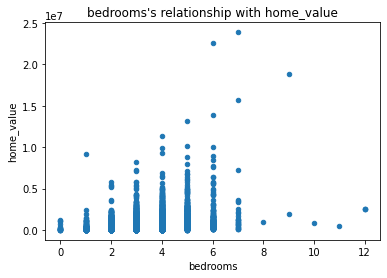

In [37]:
correlation_exploration(df, "bedrooms", "home_value")

The p-value is: 0.0.  There is 0.0% chance that we see these results by chance.
r = 0.52


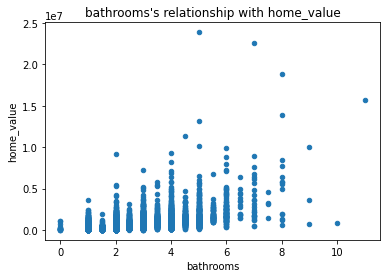

In [38]:
correlation_exploration(df, "bathrooms", "home_value")

The p-value is: 0.0.  There is 0.0% chance that we see these results by chance.
r = 0.6


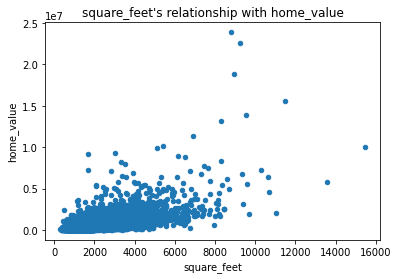

In [39]:
correlation_exploration(df, "square_feet", "home_value")

#### all r-values here in Faith's useful function check out when compared to the r-values in the heat map above

###  Time for some evaluation

In [65]:
df['yhat_baseline'] = df['home_value'].mean()
df.head(3)

,bathrooms,bedrooms,square_feet,fips,home_value,yhat_baseline
0,2.0,3.0,1458.0,6037.0,136104.0,541320.11664
1,1.0,2.0,1421.0,6037.0,35606.0,541320.11664
2,3.0,4.0,2541.0,6059.0,880456.0,541320.11664


In [71]:
rmse = (sqrt(mean_squared_error(y_train, train.yhat_baseline)))


AttributeError: 'DataFrame' object has no attribute 'yhat_baseline'

In [54]:
X = df[["bathrooms", "bedrooms", "square_feet"]]
y = df[["home_value"]]

# baseline_yhat = y.mean()

# baseline_yhat

# yielded:

# home_value    541320.11664
# dtype: float64

df.head()

,bathrooms,bedrooms,square_feet,fips,home_value
0,2.0,3.0,1458.0,6037.0,136104.0
1,1.0,2.0,1421.0,6037.0,35606.0
2,3.0,4.0,2541.0,6059.0,880456.0
3,2.0,3.0,1650.0,6037.0,614000.0
4,1.0,2.0,693.0,6037.0,274237.0


In [41]:
baseline_yhat = y.median()
baseline_yhat

home_value    384885.0
dtype: float64

#### While mean is most often used, selecting median for yhat because I need it to be robust against outliers - looks like my baseline - yhat - value is `$`384,885.00

### Time to make a model

In [42]:
from statsmodels.formula.api import ols

In [43]:
ols_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet', data=train).fit()

#### Predict on this model...

In [73]:
ols_yhat = ols_model.predict(X_train)
ols_yhat

1233     2.476356e+05
6499     3.351208e+05
6025     2.700917e+05
3160     5.344215e+05
13880    7.281262e+05
             ...     
5224    -1.574558e+05
12270    9.352954e+05
1350     1.125604e+06
11662    6.249738e+05
3587     1.236891e+05
Length: 12009, dtype: float64

#### And evaluate it against the baseline from earlier

1.) Mini df to evaluate my model against baseline

2.) Add baseline value column

3.) Add ols Predictions 

4.) Calculate and add residuals column for plotting

In [53]:
mini_df = y_train.copy()
mini_df.head()

1233     453460.0
6499     477113.0
6025     354054.0
3160     118128.0
13880    774974.0
Name: home_value, dtype: float64

### Narrow this down to the top two features

- A little Recursive Feature Elimination to go through our model and thin the feature herd.

#### Step 1 (after, of course, making sure the library is imported):

In [ ]:
# Initialize the Linear Regression Object

lm = LinearRegression()

rfe = RFE(lm, 2)

# Transform data using RFE:

X_rfe = rfe.fit_transform(X_train, y_train)

#### Step 2: Get the feature names that were selected

In [ ]:
# boolean mask to tell us which was selected ("True") and which was not ("False")

mask = rfe.support_

# select the column names for the features that are "True" and convert them to a list

rfe_features = X_train.columns[mask]

# Print them out so I can see them:

print(f"RFE selected {len(rfe_features)} features: ", ", ".join(rfe_features))

### Now, the actual modeling:

1.) Initialize the ML Algorithm Object

2.) Fit the model

3.) Predict y-values

In [76]:
#1.) Initialize

lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [77]:
#2.) Fit to the model

lm.fit(X_rfe, y_train)

NameError: name 'X_rfe' is not defined

In [ ]:
# Under the hood:

print("Linear Model:", lm)

print("Intercept:" , lm.intercept_)

print("Features:", rfe_features)

print("Coefficients:", lm.coef_)

#### The model's been fit to the X_rfe, but the negative coefficient (-76603.736 and change) is telling me that as X increases, y (the dependent variable) decreases.  Inverse proportionality es no bueno.

In [75]:
#3.) Predict y

y_train["yhat_lm"] = lm.predict(X_rfe)

y_train.head()

NameError: name 'lm' is not defined

### Our linear regression model is NOT outperforming the baseline we set earlier.  Not by a longshot.  Therefore, another model would be more appropriate.

#### Try Polynomial Regression because the relationships don't appear to be linear

In [74]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

poly.get_feature_names()

NameError: name 'X_rfe' is not defined

In [ ]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.bathrooms)
y_train["yhat_poly"] = lm_poly.predict(X_poly)